<h1><center>ROC & AUC for a Logisitic Regression Model with a TF-IDF Vectoriser</center></h1>

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

<h2><center>ROC curve for each OVR classification set plus micro and macro ROC curve</center></h2>

## 1. Model Intialisation

## 2. Confusion Matrix

## 3. ROC AUC Graph

<hr>

# 1. Model Initialisation

## Imports

In [155]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import string
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
import re
from sklearn.multiclass import OneVsRestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

import requests
import io

## Initialise Logistic Regression model

In [156]:
                        # Reading .csv file

# Training csv file
url_train = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-train.csv"
csv_train = requests.get(url_train).content
df_train = pd.read_csv(io.StringIO(csv_train.decode('utf-8')))

# Testing csv file
url_test = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-test.csv"
csv_test = requests.get(url_test).content
df_test = pd.read_csv(io.StringIO(csv_test.decode('utf-8')))

X_train = df_train['text'].astype(str)
Y_train = df_train['sentiment'].astype(str)

X_test = df_test['text'].astype(str)
Y_test = df_test['sentiment'].astype(str)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Creating custom cleaner function

Lemmatiser = nltk.stem.WordNetLemmatizer()
# Instantiating the NLTK Lemmatiser

punctuations = string.punctuation
# Putting punctuation symbols into an object

stopwords = STOP_WORDS
# A list of stopwords that can be filtered out
    # NLTK also has a stop words object but it has fewer words

def text_cleaner(sentence):    
                
    sentence = "".join([char for char in sentence.strip() if char not in punctuations])
    # Getting rid of any punctuation characters
    
    myTokens = re.split('\W+', sentence)
    # Tokenising the words
    
    myTokens = [token.lower() for token in myTokens if token not in stopwords]
    # Removing stop words
    
    myTokens = [Lemmatiser.lemmatize(token) for token in myTokens]
    # Lemmatising the words and putting in lower case except for proper nouns
    
    return myTokens 

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Creating Bag-of-Words Vectoriser

tfidf_vector = TfidfVectorizer(tokenizer = text_cleaner)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Building OVR Logisitic Regression Classifier

LogReg = LogisticRegression(max_iter=1000)

ovr = OneVsRestClassifier(LogReg)

pipe = Pipeline([('vectorizer', tfidf_vector)
                 ,('classifier', ovr)])

pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function text_cleaner at 0x000002B7D50AD828>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                          

# 2. Confusion Matrix

## Metrics & Scoring Function (*from Alex McGrigor*)

In [157]:
def get_metrics(Y_test, y_predicted):  
    
    # true positives / (true positives+false positives)
    precision = precision_score(Y_test, y_predicted, pos_label=None,
                                    average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(Y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(Y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(Y_test, y_predicted)
    
    return accuracy, precision, recall, f1

## Predict from model

In [158]:
predicted = pipe.predict(X_test)

## Build the Confusion Matrix from the results

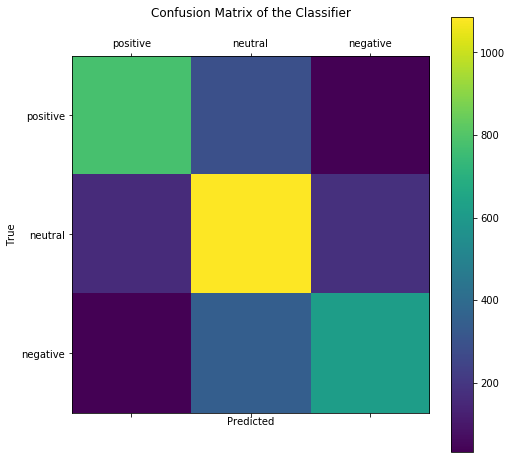

[[ 781  289   33]
 [ 164 1086  180]
 [  36  346  619]]


In [159]:
accuracy, precision, recall, f1 = get_metrics(Y_test, predicted)

#labels = [2,1,0]
labels = ['positive','neutral','negative']

cm = metrics.confusion_matrix(Y_test, predicted, labels)
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix of the Classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(cm)

# 3. ROC AUC Graph

## Binarise Y_test

In [160]:
sentiments = ['negative', 'neutral', 'positive']

Y_test = label_binarize(Y_test, classes=sentiments)
# 0 = negative - 1 = neutral - 2 = positive
    # If you change the order of the sentiments, the graph goes weird

n_classes = Y_test.shape[1]

## Predict the probabilities

In [161]:
y_score = pipe.predict_proba(X_test)

## Loop through each curve plus compute macro and micro-average curves

In [162]:
                        # Each binary classification in the OVR model

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Micro-average

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Compute micro-average ROC curve and ROC area

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Macro-average

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\nathi_000\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


## Plot all the curves

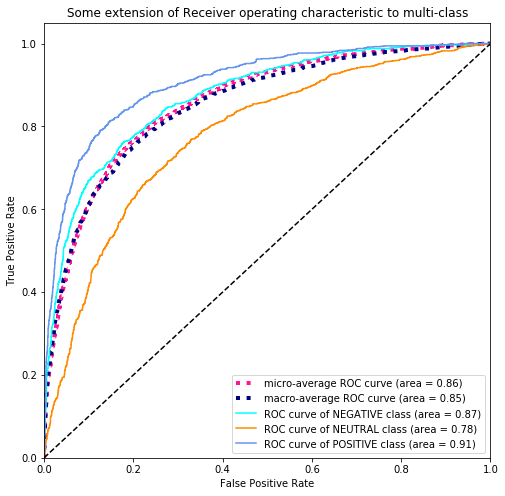

In [168]:
# Plot all ROC curves

plt.figure(figsize=[8,8])
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color, sentiment in zip(range(n_classes), colors, sentiments):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(sentiment.upper(), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()